Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine, fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR

from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingClassifier, StackingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error, r2_score

Intaking Datasets

In [ ]:
# Classification dataset (Wine)
data_clf = load_wine()
X_clf = pd.DataFrame(data_clf.data, columns=data_clf.feature_names)
y_clf = pd.Series(data_clf.target)

# Regression dataset (California Housing)
data_reg = fetch_california_housing()
X_reg = pd.DataFrame(data_reg.data, columns=data_reg.feature_names)
y_reg = pd.Series(data_reg.target)

print("Classification dataset shape:", X_clf.shape)
print("Regression dataset shape:", X_reg.shape)

Classification dataset shape: (178, 13)
Regression dataset shape: (20640, 8)


Data Preprocessing

In [ ]:
# Train-test split and scaling for classification
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf)
scaler_c = StandardScaler()
Xc_train = scaler_c.fit_transform(Xc_train)
Xc_test = scaler_c.transform(Xc_test)

# Train-test split and scaling for regression
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)
scaler_r = StandardScaler()
Xr_train = scaler_r.fit_transform(Xr_train)
Xr_test = scaler_r.transform(Xr_test)

print("Preprocessing done.")

Preprocessing done.


Classification Models

In [ ]:
# Base learners
dt_clf = DecisionTreeClassifier(random_state=42)
lr_clf = LogisticRegression(max_iter=1000, random_state=42)
svc_clf = SVC(probability=True, random_state=42)

# Ensemble models
# Changed base estimator to SVC for Bagging
bag_clf = BaggingClassifier(estimator=svc_clf, n_estimators=50, random_state=42)
# Reduced max_depth for Random Forest to reduce overfitting
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)
ada_clf = AdaBoostClassifier(n_estimators=50, random_state=42)
gb_clf = GradientBoostingClassifier(n_estimators=100, random_state=42)
vote_clf = VotingClassifier(estimators=[('dt', dt_clf), ('lr', lr_clf), ('svc', svc_clf)], voting='soft')
stack_clf = StackingClassifier(estimators=[('dt', dt_clf), ('lr', lr_clf), ('svc', svc_clf)], final_estimator=LogisticRegression())

models_clf = {
    "Decision Tree": dt_clf,
    "Logistic Regression": lr_clf,
    "SVM": svc_clf,
    "Bagging": bag_clf,
    "Random Forest": rf_clf,
    "AdaBoost": ada_clf,
    "Gradient Boosting": gb_clf,
    "Voting": vote_clf,
    "Stacking": stack_clf
}

# Train models
for name, model in models_clf.items():
    model.fit(Xc_train, yc_train)
    print(f"{name} trained.")

Decision Tree trained.
Logistic Regression trained.
SVM trained.
Bagging trained.
Random Forest trained.
AdaBoost trained.
Gradient Boosting trained.
Voting trained.
Stacking trained.


Classification Results & Visualization

                     Accuracy  Precision    Recall        F1
Decision Tree        0.944444   0.951389  0.944444  0.944961
Logistic Regression  0.972222   0.974074  0.972222  0.971970
SVM                  0.972222   0.974074  0.972222  0.971970
Bagging              0.944444   0.951389  0.944444  0.943210
Random Forest        1.000000   1.000000  1.000000  1.000000
AdaBoost             0.916667   0.922466  0.916667  0.916529
Gradient Boosting    0.944444   0.946581  0.944444  0.944269
Voting               0.972222   0.974074  0.972222  0.971970
Stacking             0.944444   0.951389  0.944444  0.943210


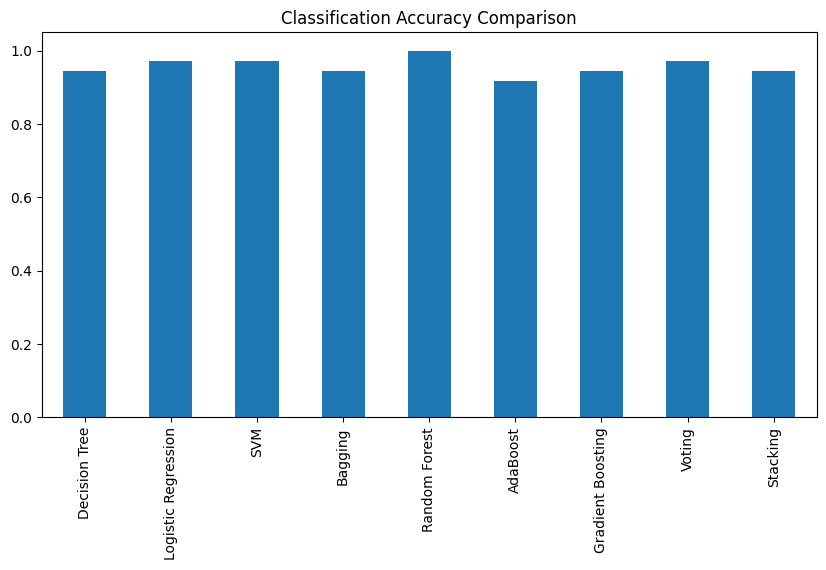

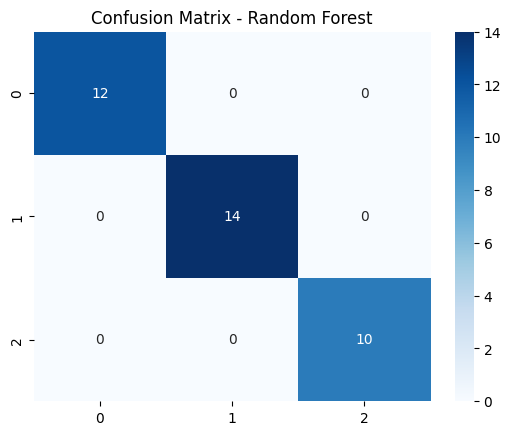

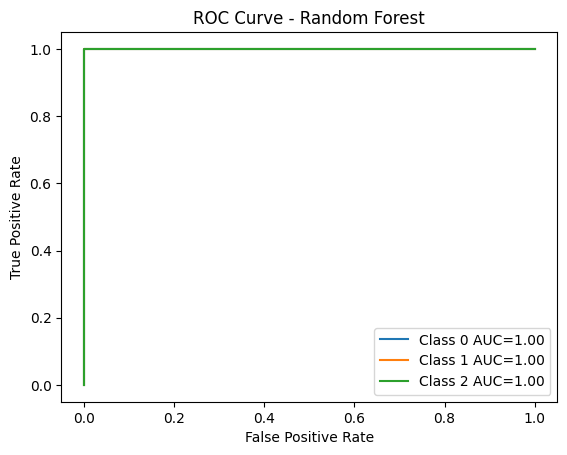

In [ ]:
results_clf = {}

for name, model in models_clf.items():
    y_pred = model.predict(Xc_test)
    acc = accuracy_score(yc_test, y_pred)
    prec = precision_score(yc_test, y_pred, average="weighted")
    rec = recall_score(yc_test, y_pred, average="weighted")
    f1 = f1_score(yc_test, y_pred, average="weighted")
    results_clf[name] = [acc, prec, rec, f1]

results_clf_df = pd.DataFrame(results_clf, index=["Accuracy", "Precision", "Recall", "F1"]).T
print(results_clf_df)

# Plot accuracy comparison
results_clf_df["Accuracy"].plot(kind="bar", figsize=(10,5), title="Classification Accuracy Comparison")
plt.show()

# Confusion matrix for best model
best_model_name = results_clf_df["Accuracy"].idxmax()
best_model = models_clf[best_model_name]
y_pred_best = best_model.predict(Xc_test)
cm = confusion_matrix(yc_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

# ROC curve for best model (multiclass handled one-vs-rest)
if hasattr(best_model, "predict_proba"):
    from sklearn.preprocessing import label_binarize
    y_bin = label_binarize(yc_test, classes=np.unique(y_clf))
    y_proba = best_model.predict_proba(Xc_test)
    for i in range(y_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {i} AUC={auc(fpr, tpr):.2f}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {best_model_name}")
    plt.legend()
    plt.show()

Regression Models

In [ ]:
# Base learners
dt_reg = DecisionTreeRegressor(random_state=42)
lr_reg = LinearRegression()
svr_reg = SVR()

# Ensemble models
bag_reg = BaggingRegressor(estimator=dt_reg, n_estimators=50, random_state=42)
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
gb_reg = GradientBoostingRegressor(n_estimators=100, random_state=42)

models_reg = {
    "Decision Tree": dt_reg,
    "Linear Regression": lr_reg,
    "SVM": svr_reg,
    "Bagging": bag_reg,
    "Random Forest": rf_reg,
    "Gradient Boosting": gb_reg
}

# Train models
for name, model in models_reg.items():
    model.fit(Xr_train, yr_train)
    print(f"{name} trained.")

Decision Tree trained.
Linear Regression trained.
SVM trained.
Bagging trained.
Random Forest trained.
Gradient Boosting trained.


Regression Results & Visualizations

                        MSE      RMSE        R2
Decision Tree      0.493969  0.702829  0.623042
Linear Regression  0.555892  0.745581  0.575788
SVM                0.357004  0.597498  0.727563
Bagging            0.256982  0.506934  0.803892
Random Forest      0.255170  0.505143  0.805275
Gradient Boosting  0.293999  0.542217  0.775643


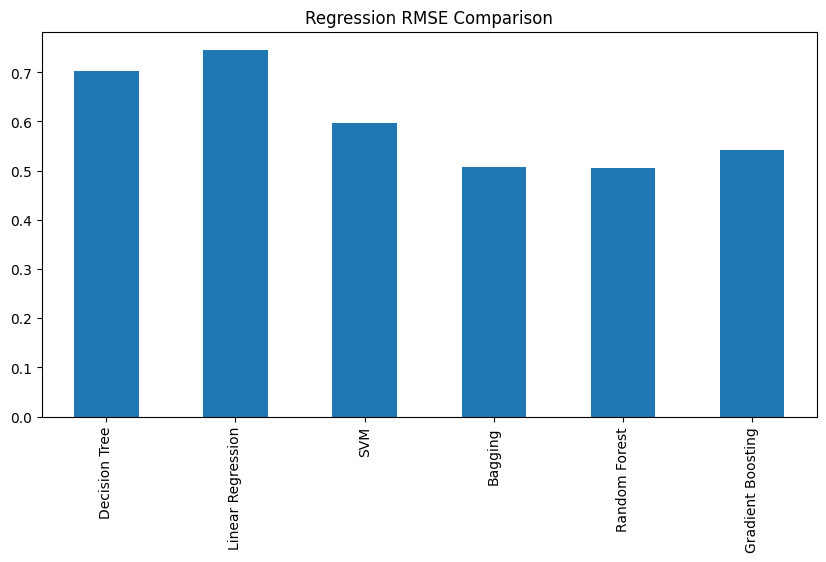

In [ ]:
results_reg = {}

for name, model in models_reg.items():
    y_pred = model.predict(Xr_test)
    mse = mean_squared_error(yr_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(yr_test, y_pred)
    results_reg[name] = [mse, rmse, r2]

results_reg_df = pd.DataFrame(results_reg, index=["MSE", "RMSE", "R2"]).T
print(results_reg_df)

# Plot RMSE comparison
results_reg_df["RMSE"].plot(kind="bar", figsize=(10,5), title="Regression RMSE Comparison")
plt.show()

